# Find informative regions for ASAP-seq and DOGMA-seq T cell stimulation experiments
Conda environment: lpr_scregseg

Considerations:
- There are 6 ATAC-seq T cell stimulaton datasets available, 2 from the ASAP-seq protocol and 4 from the DOGMA-seq protocol:
    - ASAP_LLL_CTRL
    - ASAP_LLL_STIM
    - DOGMA_LLL_CTRL
    - DOGMA_LLL_STIM
    - DOGMA_DIG_STIM
    - DOGMA_DIG_CTRL
    - The raw data lives in subfolders of ```liam_manuscript_reproducibility/data/original/Mimitou```
    - In contrast to ArchR which needs 10x-like formatted fragments files, ScregSeg needs normal gzipped files! The raw data already has the right format

# Processing raw data
Follow tutorial: https://nbviewer.jupyter.org/github/BIMSBbioinfo/scregseg/blob/master/tutorials/01-preprocessing.ipynb

In [1]:
import os
import pandas as pd
from anndata import read_h5ad
import scanpy as sc
import scregseg
import matplotlib.pyplot as plt
import scipy
import numpy as np

# Concatenate ScregSeg count matrices of all samples after first pass
Additionally remove outliers with many counts. This was done here "manually" and not with ScregSeg, as ScregSeg needs as input a specific cutoff, however, I want a data adaptive cutoff. After evaluating the data distributions I decided to remove datapoints lying outside the + 1.5 IQR.


What happens at first pass?
- make_tile
- fragments_to_counts
- subset
- filter

The count matrices that are used as input for ScregSeg have dimensions fragments by cells!



In [2]:
wd = "./../../data/derived/Mimitou2021/ATAC/"

In [3]:
! ls ./../../data/derived/Mimitou2021/ATAC/

20211222_First_tries
ArrowFiles
countmatrix_ASAP_LLL_CTRL.h5ad
countmatrix_ASAP_LLL_STIM.h5ad
countmatrix_DOGMA_DIG_CTRL.h5ad
countmatrix_DOGMA_DIG_STIM.h5ad
countmatrix_DOGMA_LLL_CTRL.h5ad
countmatrix_DOGMA_LLL_STIM.h5ad
Doublet_tests_after_first_pass
filtered_countmatrix_ASAP_LLL_CTRL.h5ad
filtered_countmatrix_ASAP_LLL_STIM.h5ad
filtered_countmatrix_DOGMA_DIG_CTRL.h5ad
filtered_countmatrix_DOGMA_DIG_STIM.h5ad
filtered_countmatrix_DOGMA_LLL_CTRL.h5ad
filtered_countmatrix_DOGMA_LLL_STIM.h5ad
qcontrolled_cells_all_ATAC_samples.csv
qcontrolled_cells_ASAP_LLL_CTRL.csv
qcontrolled_cells_ASAP_LLL_STIM.csv
qcontrolled_cells_DOGMA_DIG_CTRL.csv
qcontrolled_cells_DOGMA_DIG_STIM.csv
qcontrolled_cells_DOGMA_LLL_CTRL.csv
qcontrolled_cells_DOGMA_LLL_STIM.csv
subsetted_countmatrix_ASAP_LLL_CTRL.h5ad
subsetted_countmatrix_ASAP_LLL_STIM.h5ad
subsetted_countmatrix_DOGMA_DIG_CTRL.h5ad
subsetted_countmatrix_DOGMA_DIG_STIM.h5ad
subsetted_countmatrix_DOGMA_LLL_CTRL.h5ad
subsetted_countmatrix_DOGMA_LLL_STIM

In [4]:
datasets = [ f.path for f in os.scandir(wd) if "filtered" in os.path.basename(f)]

In [5]:
datasets

['./../../../data/derived/Mimitou2021/ATAC/filtered_countmatrix_DOGMA_LLL_STIM.h5ad',
 './../../../data/derived/Mimitou2021/ATAC/filtered_countmatrix_DOGMA_DIG_CTRL.h5ad',
 './../../../data/derived/Mimitou2021/ATAC/filtered_countmatrix_ASAP_LLL_STIM.h5ad',
 './../../../data/derived/Mimitou2021/ATAC/filtered_countmatrix_DOGMA_DIG_STIM.h5ad',
 './../../../data/derived/Mimitou2021/ATAC/filtered_countmatrix_DOGMA_LLL_CTRL.h5ad',
 './../../../data/derived/Mimitou2021/ATAC/filtered_countmatrix_ASAP_LLL_CTRL.h5ad']

In [6]:
def concatenate_scregseg_countmatrices_with_differing_features(datasets, outfile, remove_outliers=True):
    """
    Concatenates ScregSeg derived countmatrices with differing features, retains frag_lens attribute. If remove_ouliers=True, cells with nFrags >= Q3 + 1.5x IQR are removed.
    Please be aware, that the corresponding metadata frag_lens considers fragments from all cells that are in the fragments file with which the first count matrix is created. It is unaffected by any filtering of cells.
    
    AnnData object attribute X needs to be a sparse matrix!
    
    Parameters
    ----------
    datasets: list(str)
        List of strings of filepaths to files that should be concatenated.
    outfile: str
        Path to output file including h5ad file extension.
    """
    
    adata_DNA_fraglen_dict = dict()
    adata_DNA_raw_dict = dict()
    for dataset in datasets:
        print(dataset)
        # Be careful here!! what is the sample name??
        sample = '_'.join(os.path.basename(dataset).split("_")[2:5]).split(".")[0]
        print(sample)
        tmp_adata = sc.read_h5ad(dataset).T
        if remove_outliers:
            q1 = tmp_adata.obs.nFrags.quantile(0.25)
            q3 = tmp_adata.obs.nFrags.quantile(0.75)
            iqr = q3 - q1      
            remove_upper_outliers = tmp_adata.obs.nFrags <= q3 + 1.5 * iqr
            percent_removed = remove_upper_outliers.value_counts()[False] / remove_upper_outliers.shape[0]
            min_outlier = tmp_adata[~remove_upper_outliers.values,:].copy().obs.nFrags.min()
            print("Removing outliers...")
            print("{:2.2%} of samples were removed. Smallest outlier had {:d} nFrags.".format(percent_removed, int(min_outlier)))
            tmp_adata = tmp_adata[remove_upper_outliers.values,:].copy()
            remove_fragments_with_zero_counts = tmp_adata.X.sum(axis=0) != 0
            tmp_adata = tmp_adata[:,remove_fragments_with_zero_counts].copy()
            adata_DNA_raw_dict[sample] = tmp_adata
        else:
            adata_DNA_raw_dict[sample] = tmp_adata
        # This is for merging the fragment lengths of the countmatrices!
        adata_DNA_fraglen_dict[sample] = sc.AnnData(
            X=tmp_adata.varm["frag_lens"].T,
            var=tmp_adata.var)
    # Outer merge - keep all regions for now, for sample in which this site was not observe the value will be 0!
    sample_names = sorted(adata_DNA_fraglen_dict.keys())
    adata_concat_DNA_raw =  sc.AnnData.concatenate(*[adata_DNA_raw_dict[key] for key in sample_names],
                                                   join='outer', batch_key='batch',
                                                   batch_categories=sample_names,
                                                   uns_merge=None, index_unique='_', fill_value=None)

    # Outer merge - keep all regions for now, for sample in which this site was not observe the value will be 0!
    adata_concat_DNA_fraglen =  sc.AnnData.concatenate(*[adata_DNA_fraglen_dict[key] for key in sample_names],
                                                   join='outer', batch_key='batch',
                                                   batch_categories=sample_names,
                                                   uns_merge=None, index_unique='_', fill_value=None)

    # Combine the frag_lens metadata of all samples!
    accum_fraglens = scipy.sparse.csr_matrix((2001,adata_concat_DNA_fraglen.shape[1]), dtype=np.int64)
    for batch in adata_concat_DNA_fraglen.obs["batch"].unique():
        accum_fraglens += adata_concat_DNA_fraglen[adata_concat_DNA_fraglen.obs["batch"] == batch,:].X.copy()

    # Match dataype of scregseg output!
    adata_concat_DNA_raw.var["name"] = adata_concat_DNA_raw.var.index
    adata_concat_DNA_raw.var["chrom"] = adata_concat_DNA_raw.var["name"].apply(lambda x: x.split("_")[0]).astype("category")
    adata_concat_DNA_raw.var["start"]= adata_concat_DNA_raw.var["name"].apply(lambda x: x.split("_")[1]).astype(np.int64)
    adata_concat_DNA_raw.var["end"] = adata_concat_DNA_raw.var["name"].apply(lambda x: x.split("_")[2]).astype(np.int64)

    adata = sc.AnnData(
        X=adata_concat_DNA_raw.X.T.copy().tocsr(),
        obs=adata_concat_DNA_raw.var[["chrom", "start", "end"]],
        var=adata_concat_DNA_raw.obs,
        obsm={
            'frag_lens': accum_fraglens.T,
        },
    )
    
    adata.write_h5ad(outfile)

    return adata  

In [9]:
all_datasets_input_scregseg_second_pass_no_filtering = concatenate_scregseg_countmatrices_with_differing_features(datasets, "./../../data/derived/Mimitou2021/ATAC/all_datasets_input_scregseg_second_pass_no_filtering.h5ad", remove_outliers=False)

./../../../data/derived/Mimitou2021/ATAC/filtered_countmatrix_DOGMA_LLL_STIM.h5ad
DOGMA_LLL_STIM
./../../../data/derived/Mimitou2021/ATAC/filtered_countmatrix_DOGMA_DIG_CTRL.h5ad
DOGMA_DIG_CTRL
./../../../data/derived/Mimitou2021/ATAC/filtered_countmatrix_ASAP_LLL_STIM.h5ad
ASAP_LLL_STIM
./../../../data/derived/Mimitou2021/ATAC/filtered_countmatrix_DOGMA_DIG_STIM.h5ad
DOGMA_DIG_STIM
./../../../data/derived/Mimitou2021/ATAC/filtered_countmatrix_DOGMA_LLL_CTRL.h5ad
DOGMA_LLL_CTRL
./../../../data/derived/Mimitou2021/ATAC/filtered_countmatrix_ASAP_LLL_CTRL.h5ad
ASAP_LLL_CTRL


... storing 'sample' as categorical


In [10]:
all_datasets_input_scregseg_second_pass_no_filtering

AnnData object with n_obs × n_vars = 2678626 × 47361
    obs: 'chrom', 'start', 'end'
    var: 'sample', 'nFrags', 'batch'
    obsm: 'frag_lens'

In [11]:
# Remove outliers

In [12]:
all_datasets_input_scregseg_second_pass = concatenate_scregseg_countmatrices_with_differing_features(datasets, "./../../data/derived/Mimitou2021/ATAC/all_datasets_input_scregseg_second_pass.h5ad", remove_outliers=True)

./../../../data/derived/Mimitou2021/ATAC/filtered_countmatrix_DOGMA_LLL_STIM.h5ad
DOGMA_LLL_STIM
Removing outliers...
4.42% of samples were removed. Smallest outlier had 33553 nFrags.
./../../../data/derived/Mimitou2021/ATAC/filtered_countmatrix_DOGMA_DIG_CTRL.h5ad
DOGMA_DIG_CTRL
Removing outliers...
2.93% of samples were removed. Smallest outlier had 18139 nFrags.
./../../../data/derived/Mimitou2021/ATAC/filtered_countmatrix_ASAP_LLL_STIM.h5ad
ASAP_LLL_STIM
Removing outliers...
7.04% of samples were removed. Smallest outlier had 36878 nFrags.
./../../../data/derived/Mimitou2021/ATAC/filtered_countmatrix_DOGMA_DIG_STIM.h5ad
DOGMA_DIG_STIM
Removing outliers...
3.81% of samples were removed. Smallest outlier had 17625 nFrags.
./../../../data/derived/Mimitou2021/ATAC/filtered_countmatrix_DOGMA_LLL_CTRL.h5ad
DOGMA_LLL_CTRL
Removing outliers...
3.56% of samples were removed. Smallest outlier had 28884 nFrags.
./../../../data/derived/Mimitou2021/ATAC/filtered_countmatrix_ASAP_LLL_CTRL.h5ad
A

... storing 'sample' as categorical


In [13]:
all_datasets_input_scregseg_second_pass

AnnData object with n_obs × n_vars = 2675835 × 45394
    obs: 'chrom', 'start', 'end'
    var: 'sample', 'nFrags', 'batch'
    obsm: 'frag_lens'

In [240]:
# Percent of cells removed (overall)
((47361-45394)/47361)*100

4.153206224530732

In [14]:
all_datasets_input_scregseg_second_pass_no_filtering.X

<2678626x47361 sparse matrix of type '<class 'numpy.float32'>'
	with 495619544 stored elements in Compressed Sparse Row format>

{'whiskers': [<matplotlib.lines.Line2D at 0x2acf1f638390>,
 'caps': [<matplotlib.lines.Line2D at 0x2acf1f405cd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x2acf1f638750>],
 'medians': [<matplotlib.lines.Line2D at 0x2acf1f405610>],
 'fliers': [<matplotlib.lines.Line2D at 0x2acf1f4052d0>],
 'means': []}

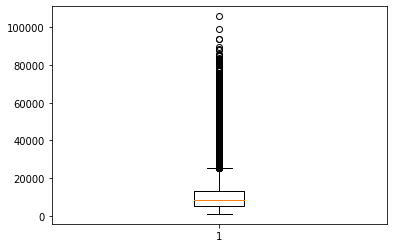

In [15]:
plt.boxplot(all_datasets_input_scregseg_second_pass_no_filtering.var.nFrags)

In [16]:
all_datasets_input_scregseg_second_pass_no_filtering.var

,sample,nFrags,batch
barcode,,,
CGAGTTATCCATTGTT-1_ASAP_LLL_CTRL,./../../../original/Mimitou2021/ASAP_seq/LLL_C...,34740.0,ASAP_LLL_CTRL
GCGGAAACACTACACA-1_ASAP_LLL_CTRL,./../../../original/Mimitou2021/ASAP_seq/LLL_C...,20223.0,ASAP_LLL_CTRL
TCTATTGCACAATAAG-1_ASAP_LLL_CTRL,./../../../original/Mimitou2021/ASAP_seq/LLL_C...,25946.0,ASAP_LLL_CTRL
CTGAATGAGCGTATCT-1_ASAP_LLL_CTRL,./../../../original/Mimitou2021/ASAP_seq/LLL_C...,20380.0,ASAP_LLL_CTRL
CAGTATGTCCTGGAAT-1_ASAP_LLL_CTRL,./../../../original/Mimitou2021/ASAP_seq/LLL_C...,18420.0,ASAP_LLL_CTRL
...,...,...,...
TAGCATATCCTAAGGT-1_DOGMA_LLL_STIM,./../../../original/Mimitou2021/DOGMA_seq/LLL_...,2535.0,DOGMA_LLL_STIM
ATAGCATGTAATGGAA-1_DOGMA_LLL_STIM,./../../../original/Mimitou2021/DOGMA_seq/LLL_...,1359.0,DOGMA_LLL_STIM
TTTGACCGTATTGCAG-1_DOGMA_LLL_STIM,./../../../original/Mimitou2021/DOGMA_seq/LLL_...,3001.0,DOGMA_LLL_STIM


In [17]:
all_datasets_input_scregseg_second_pass_no_filtering.X.sum(axis=0)

matrix([[34740., 20223., 25946., ...,  3001.,  1059.,  1021.]],
       dtype=float32)

In [18]:
all_datasets_input_scregseg_second_pass_no_filtering.X.min()

0.0

In [19]:
# nFrags == uniqueFrags, as signal was binarized! 

<AxesSubplot:>

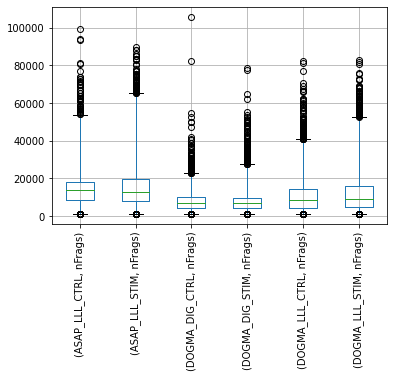

In [20]:
all_datasets_input_scregseg_second_pass_no_filtering.var.groupby("batch").boxplot("nFrags", rot=90, whis=(1,99))

<AxesSubplot:>

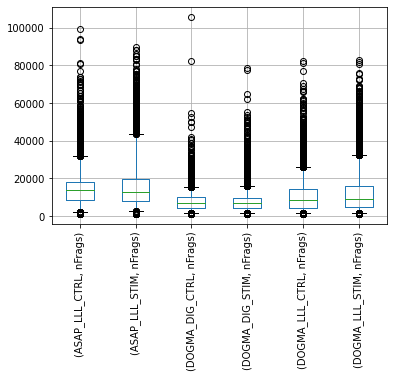

In [21]:
all_datasets_input_scregseg_second_pass_no_filtering.var.groupby("batch").boxplot("nFrags", rot=90, whis=(5,95))

<AxesSubplot:>

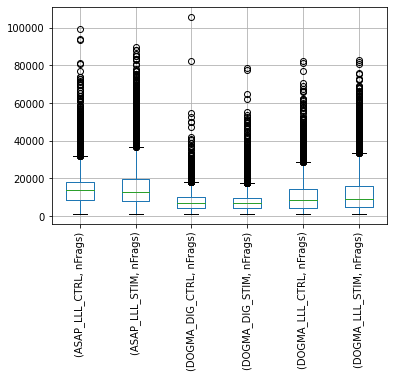

In [22]:
all_datasets_input_scregseg_second_pass_no_filtering.var.groupby("batch").boxplot("nFrags", rot=90)

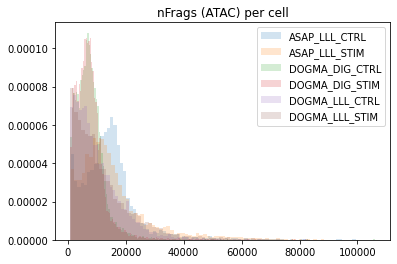

In [23]:
for sample, df in all_datasets_input_scregseg_second_pass_no_filtering.var.groupby("batch"):
    plt.hist(df.nFrags, bins="auto", label=sample, density=True, alpha=0.2)
    plt.legend(loc='upper right')
    plt.title("nFrags (ATAC) per cell")
plt.show()

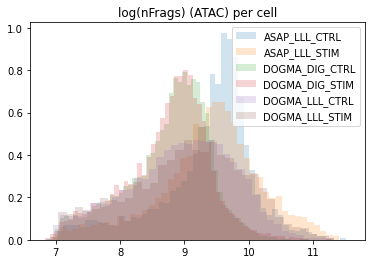

In [24]:
for sample, df in all_datasets_input_scregseg_second_pass_no_filtering.var.groupby("batch"):
    plt.hist(np.log(df.nFrags), bins="auto", label=sample, density=True, alpha=0.2)
    plt.legend(loc='upper right')
    plt.title("log(nFrags) (ATAC) per cell")
plt.show()

In [25]:
import seaborn as sns

<AxesSubplot:xlabel='nFrags', ylabel='batch'>

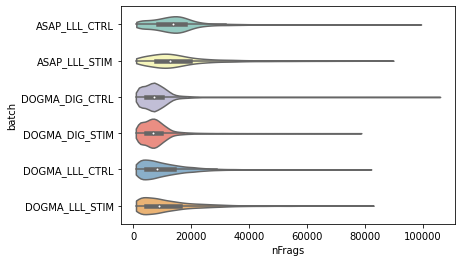

In [26]:
sns.violinplot(x=all_datasets_input_scregseg_second_pass_no_filtering.var['nFrags'], y=all_datasets_input_scregseg_second_pass_no_filtering.var['batch'], cut=0, scale="area", palette="Set3")

In [ ]:
# Distribution of data when outliers are removed

<AxesSubplot:>

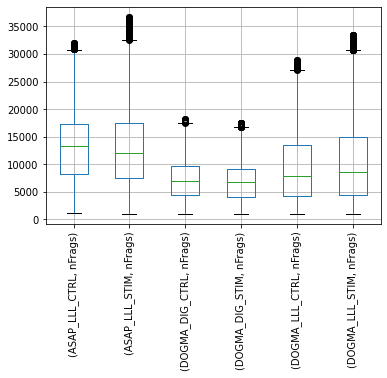

In [27]:
all_datasets_input_scregseg_second_pass.var.groupby("batch").boxplot("nFrags", rot=90)

<AxesSubplot:xlabel='nFrags', ylabel='batch'>

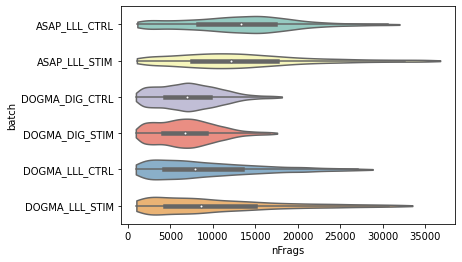

In [28]:
sns.violinplot(x=all_datasets_input_scregseg_second_pass.var['nFrags'], y=all_datasets_input_scregseg_second_pass.var['batch'], cut=0, scale="area", palette="Set3")

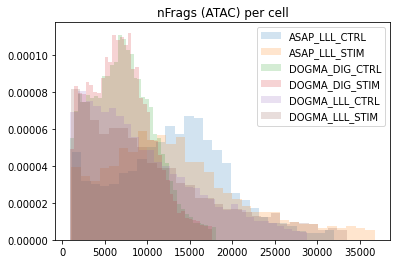

In [31]:
for sample, df in all_datasets_input_scregseg_second_pass.var.groupby("batch"):
    plt.hist(df.nFrags, bins="auto", label=sample, density=True, alpha=0.2)
    plt.legend(loc='upper right')
    plt.title("nFrags (ATAC) per cell")
plt.show()

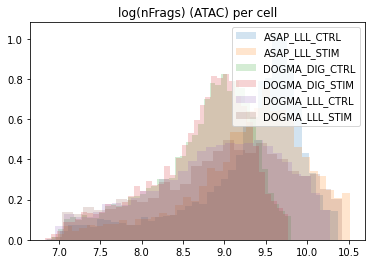

In [30]:
for sample, df in all_datasets_input_scregseg_second_pass.var.groupby("batch"):
    plt.hist(np.log(df.nFrags), bins="auto", label=sample, density=True, alpha=0.2)
    plt.legend(loc='upper right')
    plt.title("log(nFrags) (ATAC) per cell")
plt.show()

In [32]:
# Tests with scDblFinder, however, features are not yet called, and it is advised to already use peak level data

In [35]:
np.corrcoef(pd.read_csv("./../../data/derived/Mimitou2021/ATAC/Doublet_tests_after_first_pass/all_datasets_doublet_score.h5ad")["x"], all_datasets_input_scregseg_second_pass_no_filtering.var.nFrags)

array([[1.        , 0.18375885],
       [0.18375885, 1.        ]])

In [36]:
all_datasets_input_scregseg_second_pass_no_filtering.var["scDblFinder_class"] = pd.read_csv("./../../data/derived/Mimitou2021/ATAC/Doublet_tests_after_first_pass/all_datasets_doublet_class.h5ad")["x"].values

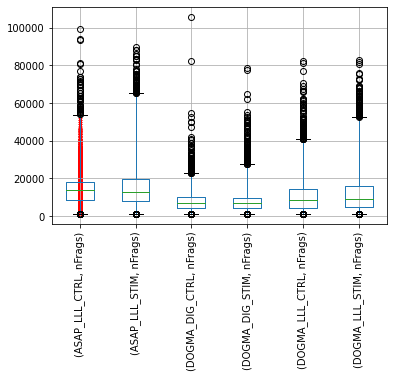

In [37]:
# Visualizing scDblFinder doublets ... fails?! all outliers are marked in first boxplot..
ax = all_datasets_input_scregseg_second_pass_no_filtering.var.groupby("batch").boxplot("nFrags", rot=90, whis=(1,99))
mask = all_datasets_input_scregseg_second_pass_no_filtering.var.scDblFinder_class == "doublet"
ax.scatter([1]*len(all_datasets_input_scregseg_second_pass_no_filtering.var[mask]['nFrags']), all_datasets_input_scregseg_second_pass_no_filtering.var[mask]['nFrags'], 
           marker='x', s=10, color='r')


In [38]:
all_datasets_input_scregseg_second_pass_no_filtering.var.scDblFinder_class

barcode
CGAGTTATCCATTGTT-1_ASAP_LLL_CTRL     singlet
GCGGAAACACTACACA-1_ASAP_LLL_CTRL     singlet
TCTATTGCACAATAAG-1_ASAP_LLL_CTRL     singlet
CTGAATGAGCGTATCT-1_ASAP_LLL_CTRL     doublet
CAGTATGTCCTGGAAT-1_ASAP_LLL_CTRL     singlet
                                      ...   
TAGCATATCCTAAGGT-1_DOGMA_LLL_STIM    singlet
ATAGCATGTAATGGAA-1_DOGMA_LLL_STIM    singlet
TTTGACCGTATTGCAG-1_DOGMA_LLL_STIM    singlet
CCTAAGGTCAATTACG-1_DOGMA_LLL_STIM    singlet
CGGTTTCTCGTTTCTG-1_DOGMA_LLL_STIM    singlet
Name: scDblFinder_class, Length: 47361, dtype: object

In [ ]:
## ASAP data  only

In [ ]:
# ASAP seq seems to have best coverage, call on all and ASAP only :)

In [44]:
datasets = [ f.path for f in os.scandir(wd) if (("filtered" in os.path.basename(f)) & ("ASAP" in os.path.basename(f)))]

In [45]:
datasets

['./../../../data/derived/Mimitou2021/ATAC/filtered_countmatrix_ASAP_LLL_STIM.h5ad',
 './../../../data/derived/Mimitou2021/ATAC/filtered_countmatrix_ASAP_LLL_CTRL.h5ad']

In [47]:
ASAP_datasets_input_scregseg_second_pass = concatenate_scregseg_countmatrices_with_differing_features(datasets, "./../../data/derived/Mimitou2021/ATAC/ASAP_datasets_input_scregseg_second_pass.h5ad", remove_outliers=True)

./../../../data/derived/Mimitou2021/ATAC/filtered_countmatrix_ASAP_LLL_STIM.h5ad
ASAP_LLL_STIM
Removing outliers...
7.04% of samples were removed. Smallest outlier had 36878 nFrags.
./../../../data/derived/Mimitou2021/ATAC/filtered_countmatrix_ASAP_LLL_CTRL.h5ad
ASAP_LLL_CTRL
Removing outliers...
4.98% of samples were removed. Smallest outlier had 32054 nFrags.


... storing 'sample' as categorical


In [48]:
ASAP_datasets_input_scregseg_second_pass

AnnData object with n_obs × n_vars = 2650360 × 9679
    obs: 'chrom', 'start', 'end'
    var: 'sample', 'nFrags', 'batch'
    obsm: 'frag_lens'

In [40]:
sc.read_h5ad("./../../data/derived/Mimitou2021/ATAC/filtered_countmatrix_DOGMA_LLL_STIM.h5ad").X.min()

0.0

In [43]:
sc.read_h5ad("./../../data/derived/Mimitou2021/ATAC/filtered_countmatrix_DOGMA_LLL_STIM.h5ad").X.max()

1.0

In [41]:
sc.read_h5ad("./../../data/derived/Mimitou2021/ATAC/filtered_countmatrix_DOGMA_LLL_STIM.h5ad").X.sum(axis=0).min()

999.0

In [42]:
sc.read_h5ad("./../../data/derived/Mimitou2021/ATAC/filtered_countmatrix_DOGMA_LLL_STIM.h5ad").X.sum(axis=1).min()

1.0